In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn
import random
import warnings

import gensim
import gensim.corpora as corpora

from gensim.models import CoherenceModel, ldamodel

from topic_modeler import TopicModeler

# Notebook settings
random.seed(123)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore') # import warnings

# Table of Contents

* [Steps performed before this notebook](http://localhost:8888/notebooks/topic_modeling.ipynb#Steps-performed-before-this-notebook)
* [Model Search (LDA)](http://localhost:8888/notebooks/topic_modeling.ipynb#Model-Search)
    * [Begin with a small corpus, and unigrams](http://localhost:8888/notebooks/topic_modeling.ipynb#Begin-with-a-small-corpus,-and-unigrams)
    * [Compare to n-grams (small corpus)](http://localhost:8888/notebooks/topic_modeling.ipynb#Compare-to-ngrams-(small-dataset))
    * [Increase size of corpus used for fitting](http://localhost:8888/notebooks/topic_modeling.ipynb#Increase-the-size-of-the-corpus-used-for-fitting)
    * [Fit model on complete corpus](http://localhost:8888/notebooks/topic_modeling.ipynb#Fit-model-on-complete-corpus)
* [Explore selected model](http://localhost:8888/notebooks/topic_modeling.ipynb#Explore-selected-model)
    * [Visualization](http://localhost:8888/notebooks/topic_modeling.ipynb#Visualization)
* [Alternative Approach: doc2vec](http://localhost:8888/notebooks/topic_modeling.ipynb#Alternative-Approach:-doc2vec)

# Model Search

To start with, we will explore fitting latent dirichlet allocation on a small dataset. Later, we'll fit the models on larger datasets and compare the coherence (we expect it to increase with the dataset size, at least up to a point).

## Begin with a small corpus, and unigrams

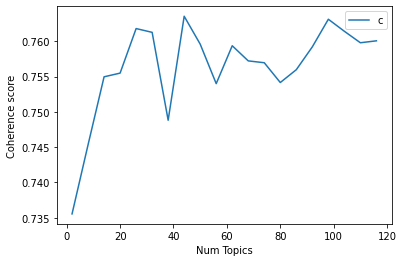

In [5]:
mod = TopicModeler('preprocessed_input/preprocessed_input_small_unigrams.json')
mod.set_texts()
mod.set_dictionary()
mod.set_corpus()

start = 2; stop = 120; step = 6
model_list, coherence_values = mod.optimal_model_search(start, stop, step)

mod.plot_model_search_results(coherence_values, start, stop, step)

The coherence value is jumping around. Note the y-axis scale (these differences are very small).

## Compare to ngrams (small dataset)

In [ ]:
model_list, coherence_values = mod.optimal_model_search(start,stop,step)

mod.plot_model_search_results(coherence_values, start, stop, step)

Overall, coherence is significantly improved when switching from unigrams to n-grams (as found with the "noun chunks" feature of the Spacy library; mostly these are bi/trigrams). However, the model seems to be converging to an optimum of a single topic. 

## Increase the size of the corpus used for fitting

Next, we re-fit the unigram and ngrams models on a larger dataset.

In [ ]:
mod1 = TopicModeler('preprocessed_input/preprocessed_input_500k_unigrams.json')
mod1.set_texts()
mod1.set_dictionary()
mod1.set_corpus()
start = 2; stop=80; step=6
model_list_unigrams, coherence_values = mod1.optimal_model_search(start,stop,step)
print('Results of model search on unigrams:')
mod1.plot_model_search_results(coherence_values, start, stop, step)

mod2 = TopicModeler('preprocessed_input/preprocessed_input_500k_ngrams.json')
mod2.set_texts()
mod2.set_dictionary()
mod2.set_corpus()
model_list_ngrams, coherence_values = mod2.optimal_model_search(start,stop,step)
print('Results of model search on ngrams:')
mod2.plot_model_search_results(coherence_values, start, stop, step)

# Explore selected model

### Summary of unigrams model

In [ ]:
mod1.set_optimal_model(model_list_unigrams, 1)
sent_topics_df, doc_topic_summary = mod1.produce_doc_topic_summary_df()
topic_summary_df = mod1.produce_topic_summary_df(sent_topics_df)
topic_summary_df.head(8)

### Summary of ngrams model:

In [ ]:
mod2.set_optimal_model(model_list_ngrams, 1)
sent_topics_df, doc_topic_summary = mod2.produce_doc_topic_summary_df()
topic_summary_df = mod2.produce_topic_summary_df(sent_topics_df)
topic_summary_df.head(8)

## Visualization

In [ ]:
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim_models.prepare(mod1.model, mod1.corpus, mod1.dictionary)
viz

In [ ]:
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim_models.prepare(mod2.model, mod2.corpus, mod2.dictionary)
viz

# Conclusion of LDA exploration

The ngram model, despite having a greater coherence metric, is seperating topics based on very specific technical terms found in the arXiv dataset. We see in visualization that virually all of the terms appper only once in the corpus or twice in the corpus.

# Alternative Approach: doc2vec

In [ ]:
#from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

mod = TopicModeler('preprocessed_input/preprocessed_input_500k_unigrams.json')
mod.set_texts()

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(mod.texts)]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
print(mod.texts[0])
vector = model.infer_vector(mod.texts[0])
print(vector)

In [ ]:
len(mod.texts)

In [ ]:
train_corpus = documents
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])
    
import collections

counter = collections.Counter(ranks)
print(counter)

In [ ]:
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

# Alternative Approach: clustering

In [22]:
# attribute: https://stackoverflow.com/questions/27889873/clustering-text-documents-using-scikit-learn-kmeans-in-python

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

corpus = []
with open('preprocessed_input/preprocessed_input_small_unigrams.json', 'r') as f:
    tmp = json.load(f)

for doc in tmp:
    corpus.append(' '.join(doc))

corpus

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus)

true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print('Cluster {}:'.format(i))
    for ind in order_centroids[i, :10]:
        print(terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
problem
agent
set
constraint
learning
weight
bushing
learn
edge
analysis


Cluster 1:
model
information
datum
network
pattern
source
approach
semantic
artificial
propose




In [23]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=data.target)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.